In [1]:
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
# Don't import too much globally like we did pyplot and numpy
# pandas will break datetime if they are imported globally.
import datetime
import pytz
import pysolar
import pandas              # pandas for data science

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
figsize(10, 5)

## Solar Radiation from a Clear Sky
The pysolar library provides functions to calculate the direct solar radiation intensity under a clear sky at a given location, accounting for attenuation through the atmosphere. This has to be further reduced because our panels are fixed and not tracking the sun, and to account for any shading by clouds or other obstructions. 
If pysolar is not already installed, you will need to open a terminal and type

pip install pysolar

or 

pip install --upgrade pysolar

to get pysolar version 0.8 or higher. https://pysolar.readthedocs.io/en/latest/

I've written the function solarR( ) to return the radiation received by a panel facing compass angle dir with surface at elevation angle elev under a clear sky. The defaults are a horizontal panel, facing south at a location in Kingston, Ontario, because that matches the situation on my sailboat. All angles are in degrees.

In [2]:
def solarR(d,elev = 0,dir = 180,latitude_deg = 44.2,longitude_deg = -76.5):
    # solar radiation falling on a surface at compass angle dir
    # and elevation angle elev under a clear sky at datetime d
    # in Kingston, Ontario
    rpd = pi / 180. # radians per degree
    azi = pysolar.solar.get_azimuth(latitude_deg, longitude_deg, d)   # azimuth angle
    alt = pysolar.solar.get_altitude(latitude_deg, longitude_deg, d)  # altitude angle
    # Unit vector pointing at the sun. RHR coords with x west, y south
    uVecSun = array([   sin((-180 + azi) * rpd) * cos(alt * rpd),
                        cos((-180 + azi) * rpd) * cos(alt * rpd),
                        sin(alt * rpd)])
    # Unit vector normal to the panel. RHR coords with x west, y south
    uVecPanel = array([ sin((-180 + dir) * rpd) * sin(elev * rpd),
                        cos((-180 + dir) * rpd) * sin(elev * rpd),
                        cos(elev * rpd)])
    # Reduce by the dot product between the sun vector and the panel vector
    rad = pysolar.solar.radiation.get_radiation_direct(d, alt) * dot(uVecSun,uVecPanel)
    if rad < 0: rad = 0   # sun is behind panel
    return rad

For PV generation capacity, the radiation needs to be multiplied by an effective area of solar panels. That area will be the actual area multiplied by the efficiency in turning solar energy into power in the battery -- probably about 1/7 to 1/5 of the actual surface area. The effective area is about the same as the installed capacity in kW.

For solar heat gain from a window, the radiation needs to be multiplied by an effective area for the window, including the effects of open glazed area over total area, and the transmittance of the open area.

This code looks at solar radiation intensity as a function of the time of day for both midwinter and midsummer. In both cases you will get the highest total energy from a panel facing south. The best elevation angle for the panel will depend on the time of year, since the sun will be lower in the sky in winter and higher in summer. You could adjust through the year, or just pick a fixed angle that best meets your requirements.

Note that the peak output at solar noon moves by about an hour due to daylight savings time.

Text(0,0.5,'Radiation Intensity [W/m**2]')

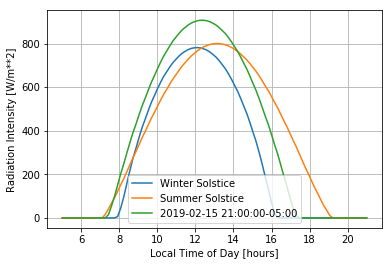

In [5]:
el = 44            # elevation of the panel, 0 degrees for horizontal
di = 180           # compass direction for the panel, 180 degrees for south

timezone = pytz.timezone("America/Toronto")  # includes Kingston
s = linspace(5,21,100)    # 0500 to 2100 covers the daytime range of interest in Kingston
i = s.copy()              # intensity vectors for differnet dates
i1 = s.copy()
i2 = s.copy()
for j in range(0,len(s)): # for all the different hours in the day 
    sh = int(s[j])        # convert to hours and minutes
    sm = int((s[j]-sh)*60)
    # pysolar 0.8 requires timezone aware datetimes
    d = timezone.localize(datetime.datetime(2018, 12, 21, sh,sm))  # December
    i[j] = solarR(d,el,di)
    d = timezone.localize(datetime.datetime(2019, 6, 21, sh,sm))   # June
    i1[j] = solarR(d,el,di)
    d = timezone.localize(datetime.datetime(2019, 2, 15, sh,sm))   # June
    i2[j] = solarR(d,el,di)

plot(s,i,label = 'Winter Solstice')
plot(s,i1,label = 'Summer Solstice')
plot(s,i2,label = d)
grid()
legend()
xlabel('Local Time of Day [hours]')
ylabel('Radiation Intensity [W/m**2]')

We can get a total insolation energy for the day by taking then mean of the intensity and multiplying by the number of hours we averaged over. The factor of 1000 converst from Watts to kiloWatts.

In [8]:
daily = mean(i) * (21-5) / 1000
daily1 = mean(i1) * (21-5) / 1000 
daily2 = mean(i2) * (21-5) / 1000 
print('For a panel facing compass direction {0:4d} deg and elevated {1:2d} deg above horizontal:'.format(di,el))
print('  Mean Daily Insolation {0:5.2f} kWh/m^2 at Summer Solstice under Clear Skies'.format(daily1))
print('                    and {0:5.2f} kWh/m^2 at Winter Solstice under Clear Skies'.format(daily))
print('                    and {0:5.2f} kWh/m^2 '.format(daily2,d),d)

For a panel facing compass direction  180 deg and elevated 44 deg above horizontal:
  Mean Daily Insolation  5.76 kWh/m^2 at Summer Solstice under Clear Skies
                    and  4.30 kWh/m^2 at Winter Solstice under Clear Skies
                    and  5.76 kWh/m^2  2019-02-15 21:00:00-05:00


## Kingston is a pretty sunny place
Still, we need data like https://www.nrcan.gc.ca/18366 to bring us back to the real world with geographic data for actual average insolation values. The Mean daily global insolation (kWh/m2 or full sun hours (h)) for each month of the year gives an idea of the actual potential for harvesting solar energy over the course of the year.

I extracted some information from that huge dataset and saved it as "Kingston ON kWh m2.csv". The raw values may be hard to read in the file, but they can be easily incorporated into a spreadsheet, or read into Python as a CSV file with pandas. All of these numbers should be smaller than the clear sky values calculated for the corresponding cases.


In [5]:
df = pandas.read_csv('Kingston ON kWh m2.csv')
df

,Province,Municipality,month,South-facing vertical (tilt=90°),South-facing tilt=latitude,South-facing tilt=lat+15°,South-facing tilt=lat-15°,Two-axis sun-tracking,Horizontal (tilt=0°)
0,Ontario,Kingston,January,3.29,3.19,3.40,2.81,3.89,1.55
1,Ontario,Kingston,February,4.11,4.32,4.48,3.94,5.33,2.50
2,Ontario,Kingston,March,4.06,5.04,4.96,4.86,6.51,3.61
3,Ontario,Kingston,April,3.08,4.94,4.54,5.10,6.90,4.42
4,Ontario,Kingston,May,2.75,5.22,4.57,5.62,7.88,5.39
5,Ontario,Kingston,June,2.62,5.42,4.62,5.96,8.65,6.01
6,Ontario,Kingston,July,2.78,5.60,4.83,6.12,8.96,6.12
7,Ontario,Kingston,August,2.99,5.21,4.68,5.48,7.66,5.12
8,Ontario,Kingston,September,3.15,4.51,4.28,4.51,6.04,3.78
9,Ontario,Kingston,October,3.19,3.79,3.80,3.57,4.70,2.46
